In [14]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# neural network
from tqdm import tqdm
import torch
import torch.nn as nn
  # our model
from LSTM import LSTM

# Data Preprocessing

In [15]:
# Stocks list

# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

In [16]:
# Download data

df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker)

    # Create the 'data' directory if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    # Save to local
    data.to_csv(f'data/{ticker}.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [17]:
df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)

    close_prices = data['Close'].rename(ticker + "_close")

    df_close = pd.concat([df_close, close_prices], axis=1)

df_close.dropna(inplace=True)

In [18]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()

df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)

# Model

In [19]:
df_to_model = df_log_return

In [20]:
df_to_model

,^GSPC_log_return,AAPL_log_return,MSFT_log_return,AMZN_log_return,NVDA_log_return,GOOGL_log_return,TSLA_log_return,META_log_return
2012-05-18 00:00:00,0.015909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00,0.000486,0.056626,0.016266,0.019725,0.017235,0.022578,0.042968,-0.116378
2012-05-22 00:00:00,0.001692,-0.007708,0.000336,-0.012828,-0.012280,-0.021912,0.068181,-0.093255
2012-05-23 00:00:00,0.001379,0.024107,-0.022083,0.009015,0.024411,0.014311,0.007118,0.031749
2012-05-24 00:00:00,-0.002168,-0.009226,-0.001375,-0.009433,-0.026886,-0.009562,-0.024145,0.031680
...,...,...,...,...,...,...,...,...
2024-05-02 00:00:00,0.012479,0.021793,0.007316,0.031455,0.032883,0.016703,0.000111,0.005653
2024-05-03 00:00:00,0.010273,0.058096,0.021928,0.008034,0.034046,0.003714,0.006534,0.023008
2024-05-06 00:00:00,0.001343,-0.009148,0.016777,0.013283,0.037046,0.005129,0.019511,0.029905
2024-05-07 00:00:00,-0.000006,0.003790,-0.010208,0.000318,-0.017363,0.018565,-0.038342,0.005482


In [21]:
Ntest = 1000
df_train = df_to_model.iloc[1:-Ntest]
df_test = df_to_model.iloc[-Ntest:-1]

X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

## Train Model

In [22]:
if torch.cuda.is_available():
    # Nvidia CUDA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Apple Metal
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


In [23]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
lstm_model = LSTM()

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'LSTM': lstm_model
}

In [24]:
results = {}

for name, model in models.items():
    print("Training: ", name)

    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    elif name == 'LSTM':
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epochs = 30

        model.to(device)
        model.train()

        for i in tqdm(range(epochs)):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X[:,:,None].to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                model.reset_hidden_state()
                y_pred = model(batch_X)

                loss = loss_function(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.to(torch.device('cpu')).item()

        model.eval()

        with torch.no_grad():
            X_test_tensor = X_test_tensor[:,:,None].to(device)
            y_pred_test = model(X_test_tensor)
            y_pred_test = y_pred_test.to(torch.device('cpu')).numpy().reshape(-1)
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )


    results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training:  NaiveForecast
Training:  LinearRegression
Training:  SVR
Training:  RFR
Training:  LSTM


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


Model: NaiveForecast
MAE: 0.0116
MSE: 0.0002
RMSE: 0.0156
direction: 0.4865


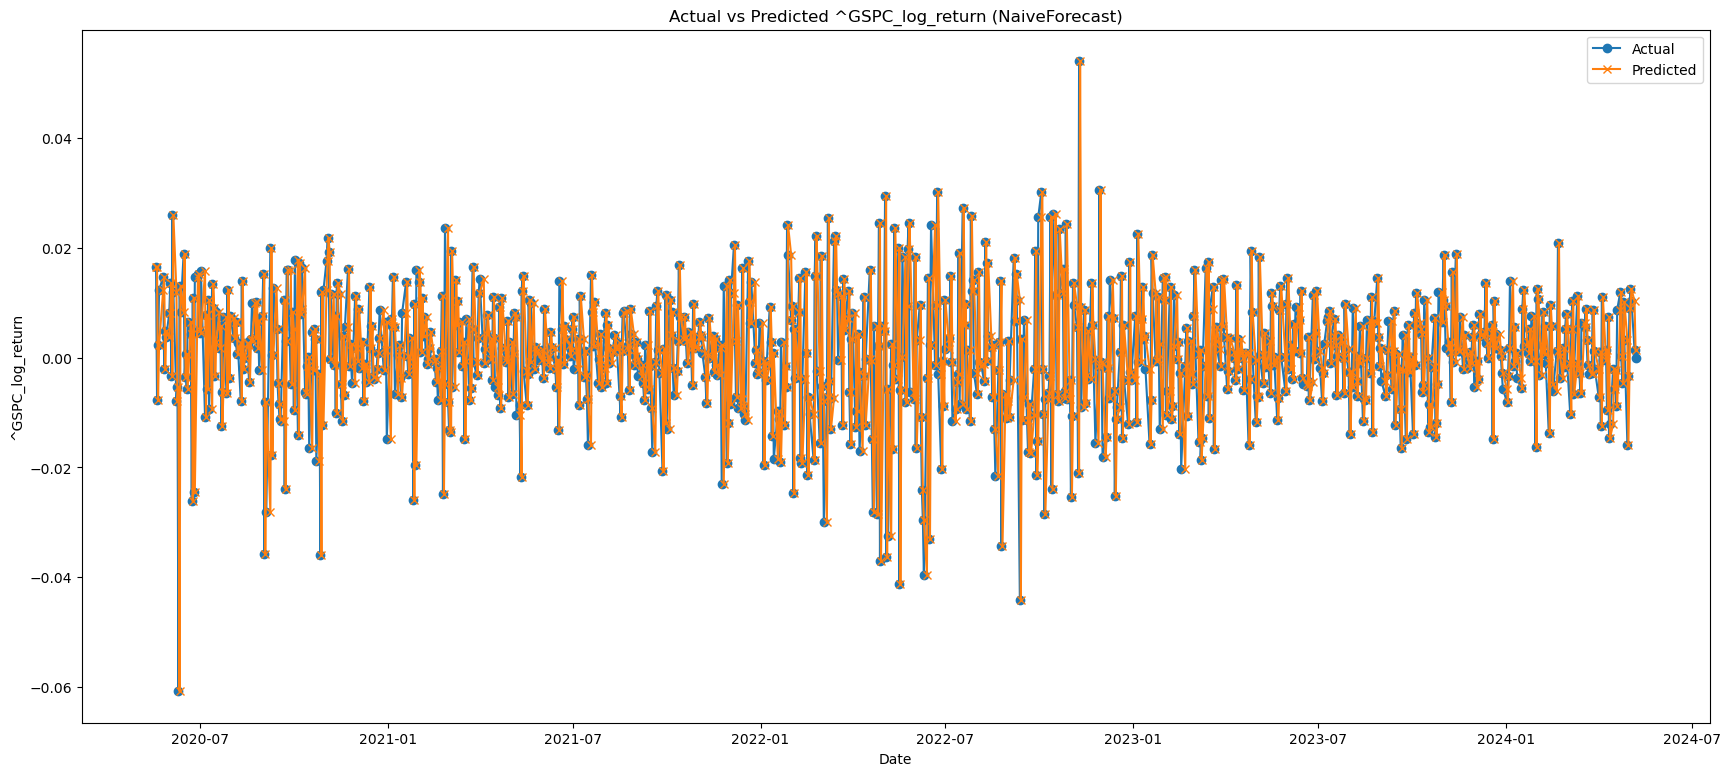

Model: LinearRegression
MAE: 0.0083
MSE: 0.0001
RMSE: 0.0111
direction: 0.5205


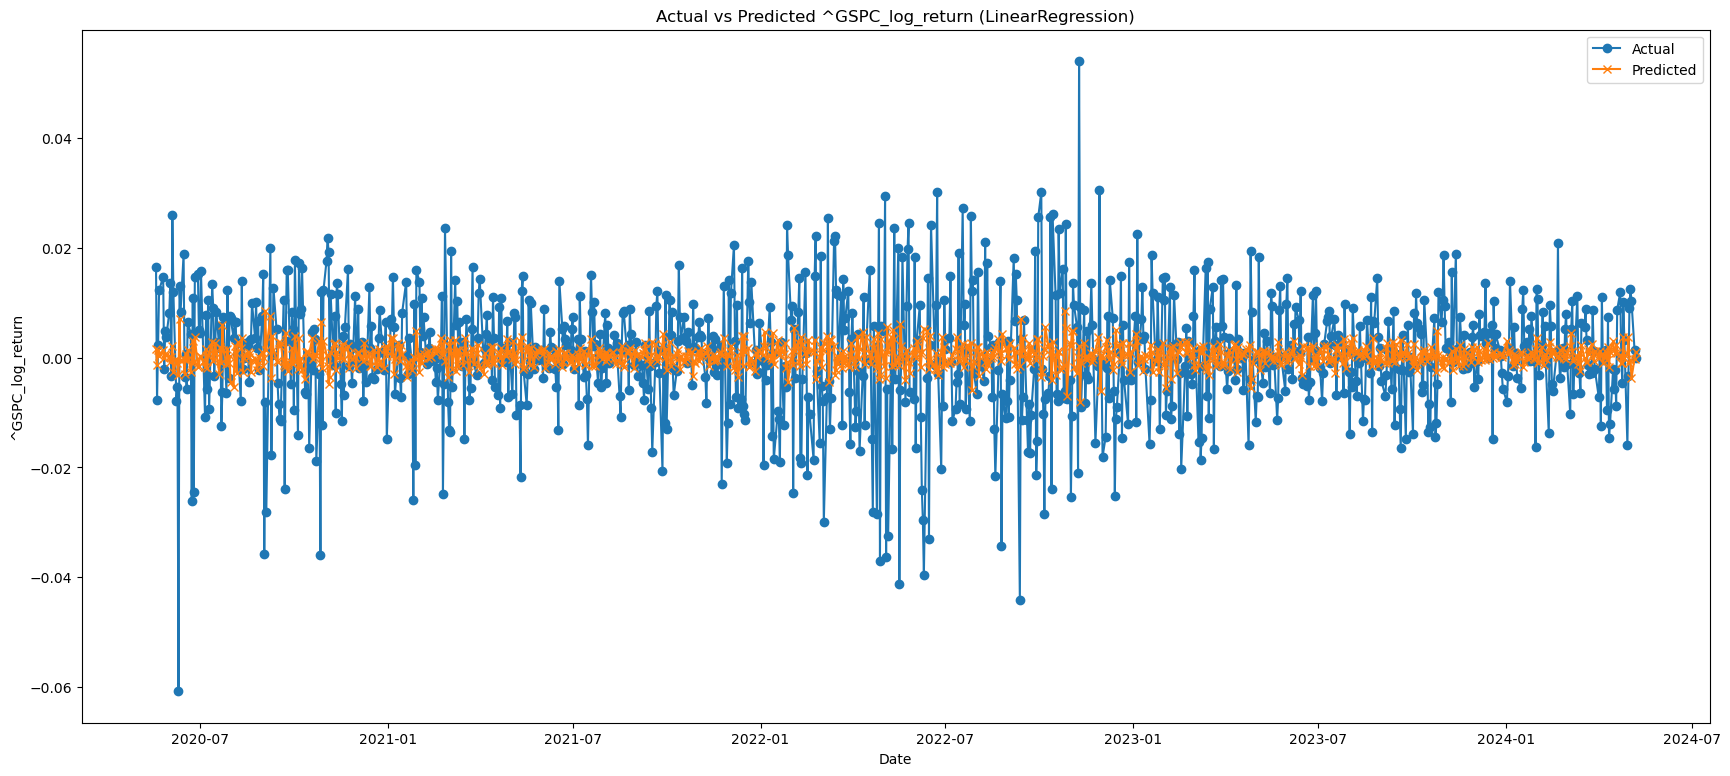

Model: SVR
MAE: 0.0168
MSE: 0.0004
RMSE: 0.0191
direction: 0.4695


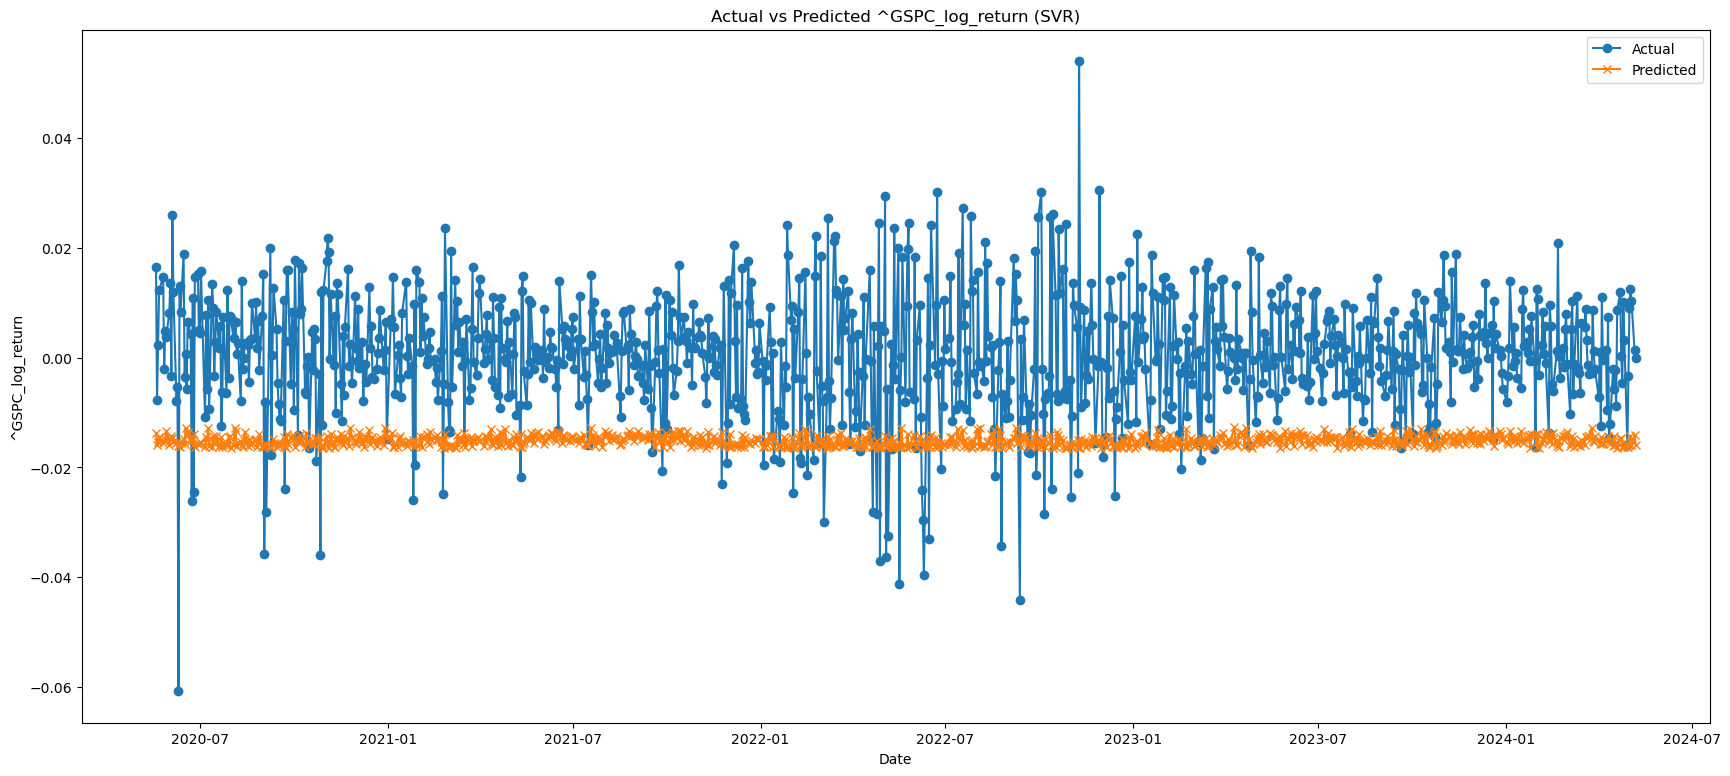

Model: RFR
MAE: 0.0087
MSE: 0.0001
RMSE: 0.0116
direction: 0.5115


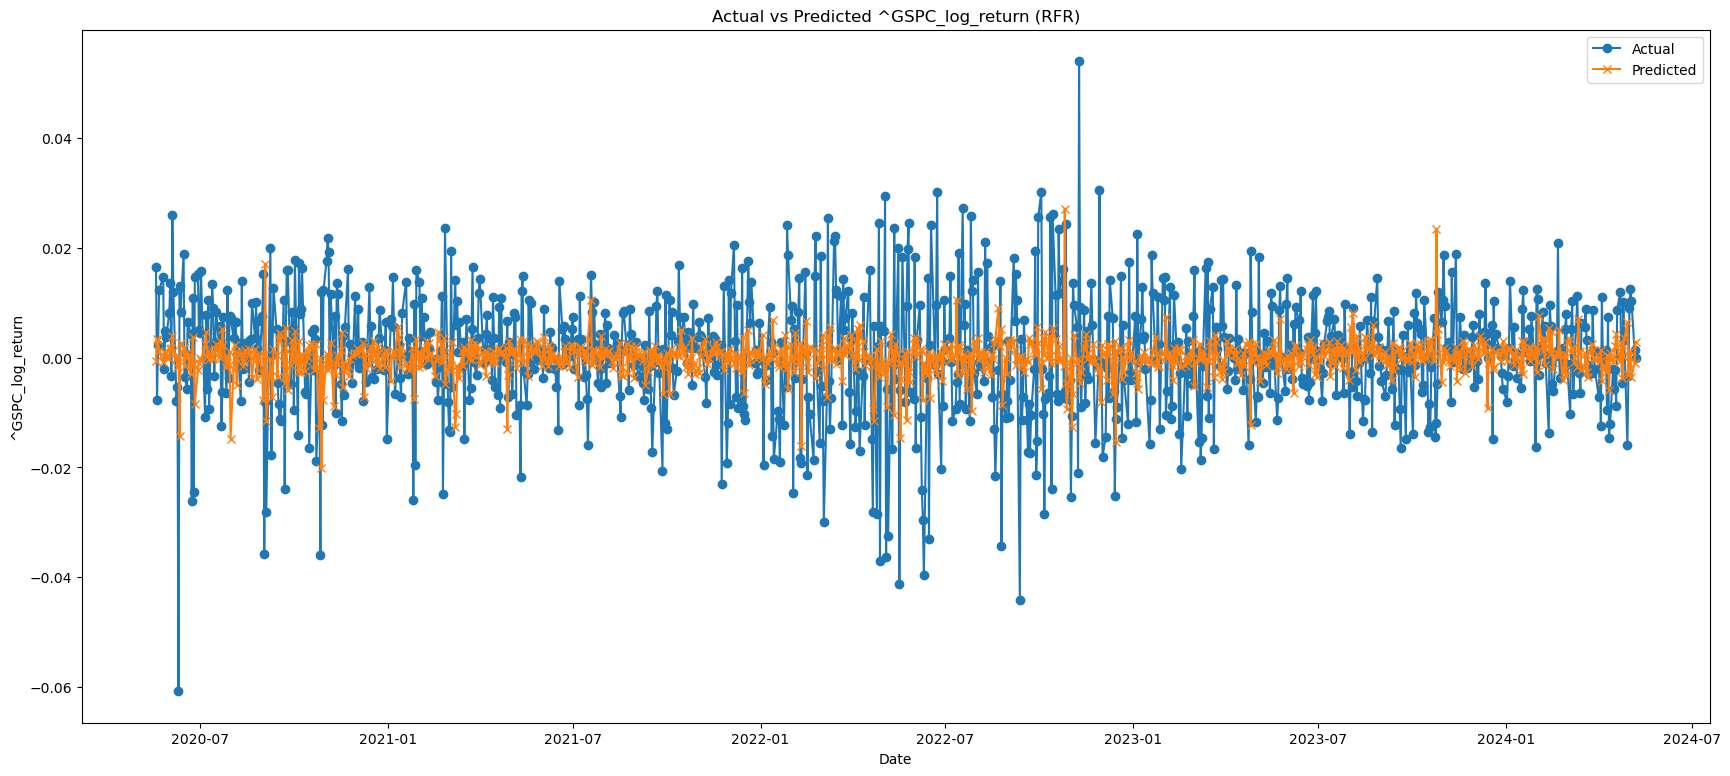

Model: LSTM
MAE: 0.0083
MSE: 0.0001
RMSE: 0.0111
direction: 0.5425


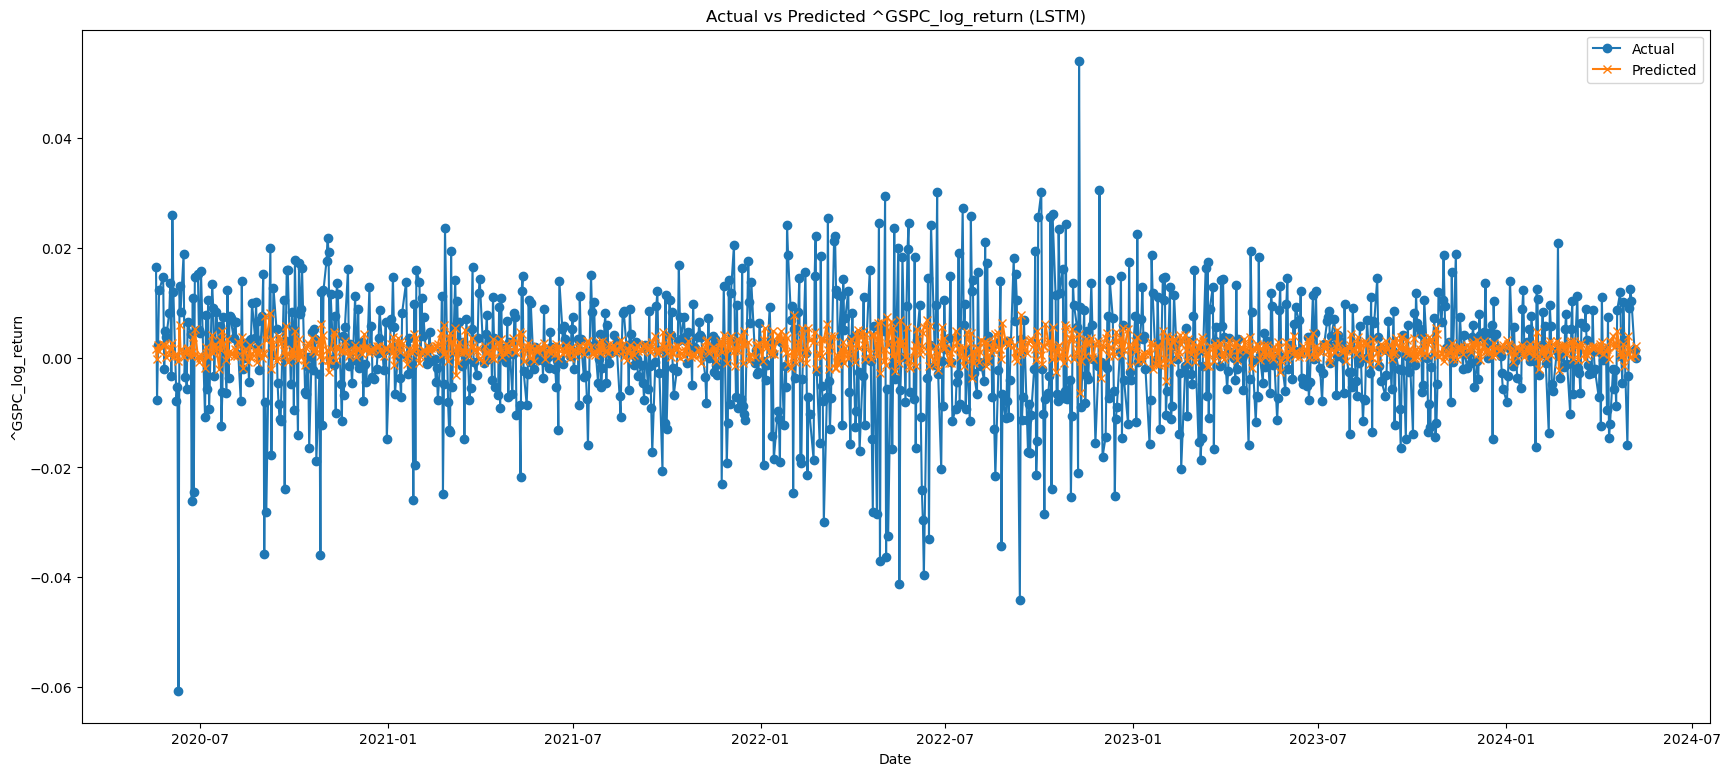

In [25]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()

# Trading

Strategy
- Position (Buy/Sell/do nothing) base on predicted '(log)return' of the next day
    - return > 0 : buy
    - return = 0 : do nothing
    - return < 0 : sell
- buy/sell all of portfolio in each transaction
- no short position

In [27]:
df_trading = pd.DataFrame() # on test set
df_trading['^GSPC_log_return'] = y_test

for model_name in models:
    pred_log_return = results[model_name]['y_pred_test']
    position = ( pred_log_return > 0 ) # 1: Buy, 0: Sell
    model_log_return = position * df_trading['^GSPC_log_return']
    df_trading[model_name + '_log_return'] = model_log_return

df_trading

,^GSPC_log_return,NaiveForecast_log_return,LinearRegression_log_return,SVR_log_return,RFR_log_return,LSTM_log_return
2020-05-19 00:00:00,0.016514,0.016514,0.016514,0.0,0.000000,0.016514
2020-05-20 00:00:00,-0.007804,-0.007804,-0.000000,-0.0,-0.007804,-0.000000
2020-05-21 00:00:00,0.002351,0.000000,0.002351,0.0,0.002351,0.002351
2020-05-22 00:00:00,0.012214,0.012214,0.012214,0.0,0.012214,0.012214
2020-05-26 00:00:00,0.014718,0.014718,0.014718,0.0,0.000000,0.014718
...,...,...,...,...,...,...
2024-05-01 00:00:00,0.009087,0.000000,0.000000,0.0,0.009087,0.009087
2024-05-02 00:00:00,0.012479,0.012479,0.000000,0.0,0.012479,0.012479
2024-05-03 00:00:00,0.010273,0.010273,0.000000,0.0,0.000000,0.010273
2024-05-06 00:00:00,0.001343,0.001343,0.000000,0.0,0.000000,0.001343


In [28]:
df_trading.index = pd.to_datetime(df_trading.index)

total_days = (df_trading.index[-1] - df_trading.index[0]).days
years = total_days // 365
months = (total_days % 365) // 30

In [29]:
buy_and_hold_total_return = np.exp(y_test.sum())

print(f'Total(Gross) Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {buy_and_hold_total_return *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {total_return *100:.2f}%')

print(f'\nNet Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1) *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1) *100:.2f}%')

print(f'\nNet Return (per year)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1)/total_days*365 *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1)/total_days*365 *100:.2f}%')

Total(Gross) Return (3 years 11 months)
----------
Buy & Hold (since 2020-05-19): 177.48%
NaiveForecast: 119.70%
LinearRegression: 167.11%
SVR: 100.00%
RFR: 141.17%
LSTM: 217.36%

Net Return (3 years 11 months)
----------
Buy & Hold (since 2020-05-19): 77.48%
NaiveForecast: 19.70%
LinearRegression: 67.11%
SVR: 0.00%
RFR: 41.17%
LSTM: 117.36%

Net Return (per year)
----------
Buy & Hold (since 2020-05-19): 19.52%
NaiveForecast: 4.96%
LinearRegression: 16.90%
SVR: 0.00%
RFR: 10.37%
LSTM: 29.56%
